In [160]:
from src.shared_imports import *

plt.style.use("seaborn-v0_8")

In [161]:
df = pd.read_csv("data/processed/gen_sen_merged.csv")
df = df.drop(['HOUR_x', 'DATE_x'], axis=1)
df["DATE_TIME"] = pd.to_datetime(df["DATE_TIME"])
df["DAY"] = df["DATE_TIME"].dt.date

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            68778 non-null  datetime64[ns]
 1   SOURCE_KEY_x         68778 non-null  object        
 2   DC_POWER             68778 non-null  float64       
 3   AC_POWER             68778 non-null  float64       
 4   DAILY_YIELD          68778 non-null  float64       
 5   TOTAL_YIELD          68778 non-null  float64       
 6   INVERTER_EFF         36827 non-null  float64       
 7   AMBIENT_TEMPERATURE  68774 non-null  float64       
 8   MODULE_TEMPERATURE   68774 non-null  float64       
 9   IRRADIATION          68774 non-null  float64       
 10  DAY                  68778 non-null  object        
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 5.8+ MB


Although the linear model in Section 2.1 achieves strong performance with an R² of approximately 0.97, the photovoltaic generation process is inherently complex, and many influencing factors exhibit nonlinear behavior.  
Therefore, multiple baseline models, such as XGBoost, are constructed and compared to obtain a more robust baseline. The selected baseline model is then used to build the PR time series for subsequent analysis.

In [163]:
df.describe()

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,INVERTER_EFF,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,68778,68778.000000,68778.000000,68778.000000,6.877800e+04,36827.000000,68774.000000,68774.000000,68774.000000
mean,2020-06-01 08:02:49.458256896,3147.426211,307.802752,3295.968737,6.978712e+06,0.097719,25.558521,31.244997,0.232305
min,2020-05-15 00:00:00,0.000000,0.000000,0.000000,6.183645e+06,0.095552,20.398505,18.140415,0.000000
25%,2020-05-24 00:45:00,0.000000,0.000000,0.000000,6.512003e+06,0.097579,22.724491,21.123944,0.000000
50%,2020-06-01 14:30:00,429.000000,41.493750,2658.714286,7.146685e+06,0.097845,24.670178,24.818984,0.031620
75%,2020-06-09 20:00:00,6366.964286,623.618750,6274.000000,7.268706e+06,0.098014,27.960429,41.693659,0.454880
max,2020-06-17 23:45:00,14471.125000,1410.950000,9163.000000,7.846821e+06,0.106592,35.252486,65.545714,1.221652
std,NaN,4036.457169,394.396439,3145.178309,4.162720e+05,0.000458,3.361300,12.308283,0.301948


Next steps:

1. Filter out nighttime data and daytime records with DC power equal to zero, as these represent abnormal operating conditions.

2. Construct input features:
   - Core physical features: IRRADIATION, MODULE_TEMPERATURE, AMBIENT_TEMPERATURE
   - Nonlinear enhancement features:  
     IRR2 = IRRADIATION²  
     TEMP2 = MODULE_TEMPERATURE²  
     IRR_TEMP = IRRADIATION × MODULE_TEMPERATURE
   - Temporal features:  
     hour = DATE_TIME.hour


In [164]:
#过滤夜间数据以及白天dc=0的异常数据
df_model = df[(df["DC_POWER"] > 0) & (df["IRRADIATION"] > 0.02)]

#添加特征
df_model["IRR2"] = df_model["IRRADIATION"] ** 2
df_model["TEMP2"] = df_model["MODULE_TEMPERATURE"] ** 2
df_model["IRR_TEMP"] = df_model["IRRADIATION"] * df_model["MODULE_TEMPERATURE"]

df_model["hour"] = df_model["DATE_TIME"].dt.hour

C:\Users\pearl\AppData\Local\Temp\ipykernel_21356\662249596.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model["IRR2"] = df_model["IRRADIATION"] ** 2
C:\Users\pearl\AppData\Local\Temp\ipykernel_21356\662249596.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model["TEMP2"] = df_model["MODULE_TEMPERATURE"] ** 2
C:\Users\pearl\AppData\Local\Temp\ipykernel_21356\662249596.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [165]:
df_model.describe()

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,INVERTER_EFF,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,IRR2,TEMP2,IRR_TEMP,hour
count,35351,35351.000000,35351.000000,35351.000000,3.535100e+04,35351.000000,35351.000000,35351.000000,35351.000000,35351.000000,35351.000000,35351.000000,35351.000000
mean,2020-06-01 05:09:48.305847040,6118.212285,598.336600,3590.235873,6.979118e+06,0.097769,27.718088,40.424037,0.450151,0.281251,1751.260859,20.992782,11.826257
min,2020-05-15 06:15:00,61.125000,5.912500,0.000000,6.183648e+06,0.095552,20.838399,18.728929,0.020407,0.000416,350.772764,0.462447,6.000000
25%,2020-05-23 18:15:00,2796.687500,274.337500,971.642857,6.514085e+06,0.097616,25.460364,31.234487,0.201037,0.040416,975.593170,6.193751,9.000000
50%,2020-06-01 10:00:00,6217.142857,609.071429,3558.125000,7.146657e+06,0.097860,27.759672,41.007432,0.444573,0.197645,1681.609474,18.348660,12.000000
75%,2020-06-09 13:37:30,9019.116072,881.652679,5843.000000,7.268389e+06,0.098020,29.951886,48.595913,0.662755,0.439244,2361.562728,31.939364,15.000000
max,2020-06-17 18:15:00,14471.125000,1410.950000,9151.000000,7.846816e+06,0.106592,35.252486,65.545714,1.221652,1.492433,4296.240580,72.549113,18.000000
std,NaN,3678.741676,359.007616,2643.757716,4.158848e+05,0.000392,3.139548,10.824113,0.280387,0.281544,882.106126,16.507624,3.492278


In [166]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

feature = ["IRRADIATION", "MODULE_TEMPERATURE", "AMBIENT_TEMPERATURE", "IRR2", "TEMP2", "IRR_TEMP", "hour"]
X_train = df_model[feature]
y_train = df_model["DC_POWER"]

xgb = XGBRegressor(
    n_estimators = 500,
    max_depth = 5,
    learning_rate = 0.05,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42
)

xgb.fit(X_train, y_train)

y_pred_train = xgb.predict(X_train)

r2_train = r2_score(y_train, y_pred_train)

print("=== XGBoost Baseline Model ===")
print("Training R² =", r2_train)

#对原数据集构建相同的特征量
df["IRR2"] = df["IRRADIATION"] ** 2
df["TEMP2"] = df["MODULE_TEMPERATURE"] ** 2
df["IRR_TEMP"] = df["IRRADIATION"] * df["MODULE_TEMPERATURE"]

df["hour"] = df["DATE_TIME"].dt.hour

df["DC_BASELINE_XGB"] = xgb.predict(df[feature])

=== XGBoost Baseline Model ===
Training R² = 0.9803816915589354


The model performance improves from an R² of 0.9646 with the linear model to an R² of 0.9803, indicating a significant gain in prediction accuracy.


In [167]:
df.describe()

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,INVERTER_EFF,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,IRR2,TEMP2,IRR_TEMP,hour,DC_BASELINE_XGB
count,68778,68778.000000,68778.000000,68778.000000,6.877800e+04,36827.000000,68774.000000,68774.000000,68774.000000,68774.000000,68774.000000,68774.000000,68778.000000,68778.000000
mean,2020-06-01 08:02:49.458256896,3147.426211,307.802752,3295.968737,6.978712e+06,0.097719,25.558521,31.244997,0.232305,0.145137,1127.741450,10.831732,11.567216,3318.669922
min,2020-05-15 00:00:00,0.000000,0.000000,0.000000,6.183645e+06,0.095552,20.398505,18.140415,0.000000,0.000000,329.074673,0.000000,0.000000,238.986801
25%,2020-05-24 00:45:00,0.000000,0.000000,0.000000,6.512003e+06,0.097579,22.724491,21.123944,0.000000,0.000000,446.221016,0.000000,6.000000,328.285034
50%,2020-06-01 14:30:00,429.000000,41.493750,2658.714286,7.146685e+06,0.097845,24.670178,24.818984,0.031620,0.001000,615.981963,0.743456,12.000000,440.678680
75%,2020-06-09 20:00:00,6366.964286,623.618750,6274.000000,7.268706e+06,0.098014,27.960429,41.693659,0.454880,0.206916,1738.361173,18.787380,17.000000,6395.738281
max,2020-06-17 23:45:00,14471.125000,1410.950000,9163.000000,7.846821e+06,0.106592,35.252486,65.545714,1.221652,1.492433,4296.240580,72.549113,23.000000,14310.929688
std,NaN,4036.457169,394.396439,3145.178309,4.162720e+05,0.000458,3.361300,12.308283,0.301948,0.246574,904.674687,15.840507,6.862477,3897.949219


### Scatter Plot


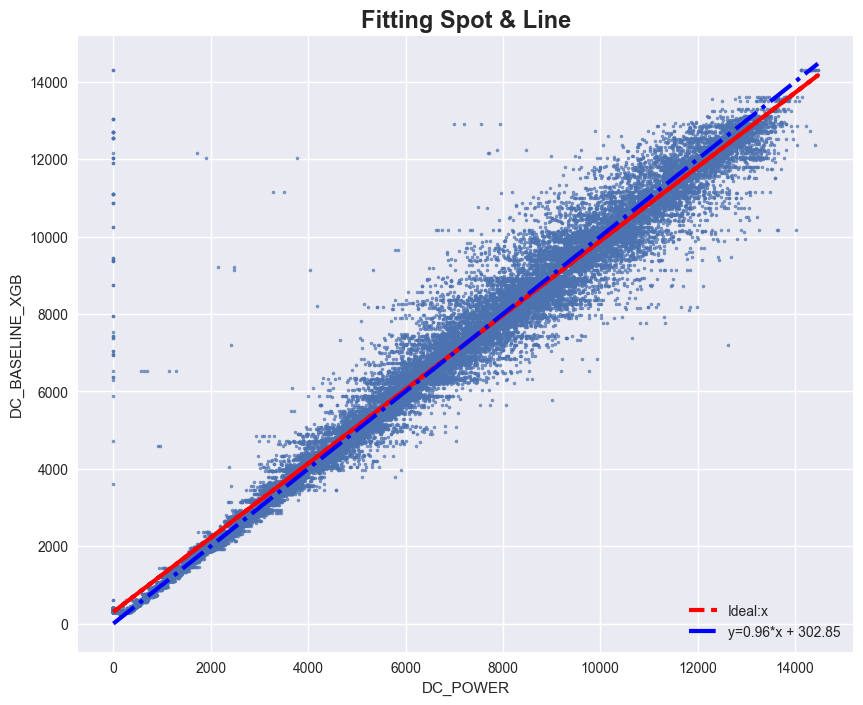

In [168]:
y_true = df["DC_POWER"]
y_pred = df["DC_BASELINE_XGB"]
plt.figure(figsize=(10,8))
plt.scatter(y_true, y_pred, alpha=0.7, s=5, marker="o")
k,b = np.polyfit(y_true, y_pred, 1)
fit_line = k*y_true + b
x_line = np.linspace(y_true.min(),y_true.max(),100)

plt.plot(y_true, fit_line, color="red",linewidth="3", linestyle="--", label= "Ideal:x")
plt.plot(x_line, x_line, color="blue", linewidth="3", linestyle="-.", label= f"y={k:.2f}*x + {b:.2f}")

plt.xlabel("DC_POWER")
plt.ylabel("DC_BASELINE_XGB")
plt.title("Fitting Spot & Line", fontsize=17, weight="bold")
plt.legend()

PR (Performance Ratio) is used to evaluate the deviation of actual DC output relative to the baseline model prediction:

**PR = Actual / Baseline**

Under normal operating conditions, PR ≈ 1.  
PR < 1 indicates performance degradation, which may be caused by:
- Local shading (e.g., trees or buildings)
- Soiling on module surfaces
- Efficiency loss due to high module temperature

The PR time series can be used for automated performance monitoring and anomaly detection, including:
- Assessing PR stability throughout the day
- Identifying sudden drops (e.g., cloud shading or inverter issues)
- Detecting long-term degradation trends (e.g., module aging)


In industry practice, PR is typically calculated only during stable daytime periods when irradiance exceeds a certain threshold (e.g., 20–50 W/m²), in order to ensure stability, interpretability, and a realistic reflection of system performance.

At low irradiance levels (such as early morning, late afternoon, or shaded conditions):
- PV output is very low and highly nonlinear, and is more sensitive to temperature, noise, and MPPT behavior
- The relationship between model predictions and actual output becomes unreliable, causing abnormal PR fluctuations
- PR may be misinterpreted as performance degradation, leading to false anomaly detection
- Power generation itself is unstable and unsuitable for performance evaluation

Therefore, an irradiance threshold of IRRADIATION > 0.02 is applied in this analysis.


In [169]:
df_pr = df[df["IRRADIATION"] > 0.02]
df_pr["PR"] = df_pr["DC_POWER"] / df_pr["DC_BASELINE_XGB"]

C:\Users\pearl\AppData\Local\Temp\ipykernel_21356\2895836832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pr["PR"] = df_pr["DC_POWER"] / df_pr["DC_BASELINE_XGB"]


In [170]:
df_pr.describe()

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,INVERTER_EFF,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,IRR2,TEMP2,IRR_TEMP,hour,DC_BASELINE_XGB,PR
count,35428,35428.000000,35428.000000,35428.000000,3.542800e+04,35351.000000,35428.000000,35428.000000,35428.000000,35428.000000,35428.000000,35428.000000,35428.000000,35428.000000,35428.000000
mean,2020-06-01 05:29:16.915434240,6104.914827,597.036162,3590.542466,6.978577e+06,0.097769,27.719073,40.435126,0.450520,0.281739,1752.250212,21.016704,11.828723,6123.055664,0.996281
min,2020-05-15 06:15:00,0.000000,0.000000,0.000000,6.183648e+06,0.095552,20.838399,18.728929,0.020407,0.000416,350.772764,0.462447,6.000000,291.921326,0.000000
25%,2020-05-24 06:15:00,2778.250000,272.604464,974.276786,6.513099e+06,0.097616,25.472194,31.234487,0.201037,0.040416,975.593170,6.193751,9.000000,2798.592773,0.964750
50%,2020-06-01 10:15:00,6203.848214,607.750000,3557.937500,7.146215e+06,0.097860,27.759672,41.007432,0.444714,0.197770,1681.609474,18.348660,12.000000,6314.988281,1.003769
75%,2020-06-09 13:45:00,9011.750000,881.215625,5840.718750,7.268115e+06,0.098020,29.951886,48.671240,0.662911,0.439451,2368.889610,32.029535,15.000000,8949.429688,1.034044
max,2020-06-17 18:15:00,14471.125000,1410.950000,9151.000000,7.846816e+06,0.106592,35.252486,65.545714,1.221652,1.492433,4296.240580,72.549113,18.000000,14310.929688,1.756158
std,NaN,3685.771073,359.698159,2642.502796,4.159059e+05,0.000392,3.137814,10.828393,0.280666,0.282026,882.632891,16.527294,3.491004,3641.302002,0.085453


In [171]:
k = ((df_pr["PR"] > 0) & (df_pr["PR"] < 1.3)).sum()
PR_outlier_num = 35428 - k

print(f"PR outlier number count :{PR_outlier_num}")
df_pr = df_pr[(df_pr["PR"] > 0) & (df_pr["PR"] < 1.3)]
df_pr = df_pr.set_index("DATE_TIME")

pr_hourly = df_pr["PR"].resample("H").mean()
pr_daily = df_pr["PR"].resample("D").mean()

print("PR 时间序列构建完成")
print("Hourly PR:", pr_hourly.head())
print("Daily PR:", pr_daily.head())

PR outlier number count :144
PR 时间序列构建完成
Hourly PR: DATE_TIME
2020-05-15 06:00:00    0.959104
2020-05-15 07:00:00    0.973401
2020-05-15 08:00:00    0.981194
2020-05-15 09:00:00    0.989532
2020-05-15 10:00:00    0.981421
Freq: h, Name: PR, dtype: float64
Daily PR: DATE_TIME
2020-05-15    0.985615
2020-05-16    1.016020
2020-05-17    0.998067
2020-05-18    1.001650
2020-05-19    1.003348
Freq: D, Name: PR, dtype: float64


C:\Users\pearl\AppData\Local\Temp\ipykernel_21356\2666695735.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pr_hourly = df_pr["PR"].resample("H").mean()


### Time Series of Daily Performance Ratio (PR)

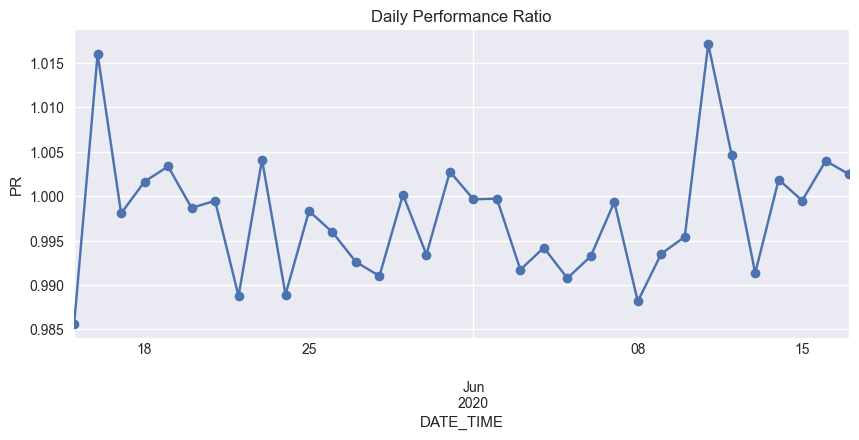

In [172]:
pr_daily.plot(figsize=(10,4), marker="o")
plt.title("Daily Performance Ratio")
plt.ylabel("PR")
plt.grid(True)
plt.show()

### Time Series of Hourly PR Trend

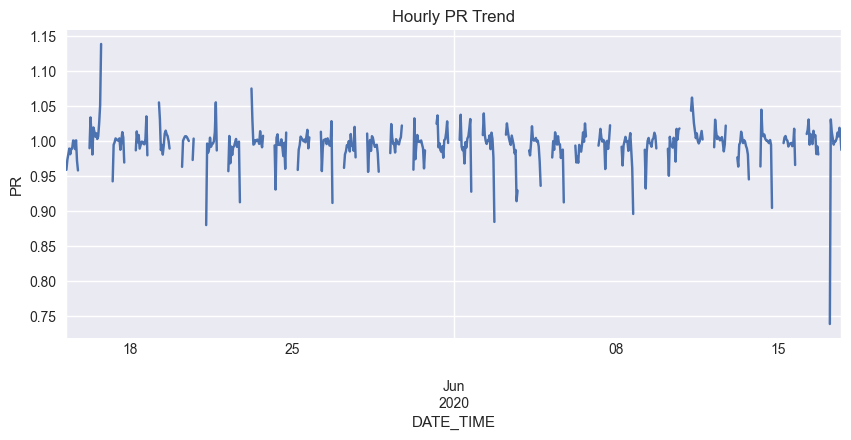

In [173]:
pr_hourly.plot(figsize=(10,4))
plt.title("Hourly PR Trend")
plt.ylabel("PR")
plt.grid(True)
plt.show()


In [176]:
abnormal_days = pr_daily[pr_daily < 0.99]
abnormal_days

DATE_TIME
2020-05-15    0.985615
2020-05-22    0.988760
2020-05-24    0.988928
2020-06-08    0.988159
Name: PR, dtype: float64

In [177]:
abnormal_hours = pr_hourly[pr_hourly < 0.90]
abnormal_hours

DATE_TIME
2020-05-21 07:00:00    0.880150
2020-06-02 18:00:00    0.884662
2020-06-08 18:00:00    0.896029
2020-06-17 06:00:00    0.738740
Name: PR, dtype: float64